<a href="https://colab.research.google.com/github/hyd3nekosuki/ReactorNoiseAnalysis/blob/main/MovingBlockBootstrapForReactorNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy problem of Feynman-$\alpha$ method using moving block bootstrap method

Reference: Tomohiro Endo, AkioYamamoto, "Comparison of theoretical formulae and bootstrap method for statistical error estimation of Feynman-$\alpha$ method," Ann. Nucl. Energy, 124, pp.606-615 (2019). DOI:[10.1016/j.anucene.2018.10.032](https://doi.org/10.1016/j.anucene.2018.10.032)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import njit

## Feynman-$\alpha$ method

In [2]:
@njit(cache=True)
def calcY(count, T0, klist):
    NY = len(klist)
    T = klist*T0
    Y = np.zeros(NY)
    Yerr = np.zeros(NY)
    for i in range(len(klist)):
        k = klist[i]
        Nk=int( np.floor(len(count)/k) )
        ck = np.zeros(Nk)    
        for j in range(k):
            ck += count[j::k][:Nk]
        ave = np.mean(ck)
        var = Nk/(Nk-1)* np.var(ck)
        y = var/ave - 1
        Y[i] = y
        Yerr[i] = (y+1)*np.sqrt(y*(2*y+1)*(5*y+2)/(Nk*(y+1)*(y+1)*ave) +2/(Nk-1)) # Simplified error estimation for Y value
    return T, Y, Yerr

In [3]:
@njit(cache=True)
def Yfunc(T, alpha, Yinf, c):
    return Yinf * (1.0 - (1.0 - np.exp(-alpha*T))/(alpha*T)) +c*T

## Analog Monte Carlo to simulate zero power reactor noise

In [4]:
@njit(cache=True)
def simulateReactorNoise(NSource, T0, NT, SigS, SigF, SigC):
    nuave = 2.4
    numax = 5
    SigA = SigF + SigC
    SigT = SigS + SigA

    ps = SigS/SigT
    pf = SigF/SigT
    pc = SigC/SigT
    v = 2200e2

    kinf = nuave*SigF/SigA
    rho = 1 - 1/kinf
    Lambda = 1/(v*nuave*SigF)
    alpha = (-rho) / Lambda
    print("kinf, rho, Lambda, alpha")
    print(kinf, rho, Lambda, alpha)

    NBank = 1000
    tcut = 10
    texp = T0*NT
    t = np.zeros(NBank)
    tnext = np.zeros(NBank)
    count = np.zeros(NT, dtype=np.int64)

    for i in range(NSource):
        Nneutrons = 1
        t[0] = np.random.uniform(-tcut, texp)
        while Nneutrons > 0:
            inext = 0
            for i in range(Nneutrons):
                tnow = t[i]
                tl = -1.0/SigT * np.log(1.0 - np.random.rand())
                tnow += tl/v
                if tnow <= texp:
                    xi = np.random.rand()
                    if xi < ps:        # scattering
                        tnext[inext] = tnow
                        inext += 1
                    elif xi < (ps+pc): # capture = detection
                        if tnow >0.0:
                            count[ int(tnow/T0) ] += 1
                    else: # fission
                        nu = np.random.binomial(numax, nuave/numax)
                        tnext[inext:(inext+nu)] = tnow
                        inext += nu
            
            Nneutrons = inext
            t = tnext.copy()  

    return count

## Moving block bootstrap method

In [5]:
@njit(cache=True)
def movingBlockBootstrap(count, klist):
    kmax = np.max(klist)
    imax = len(count)
    c = np.append(count, count[0:kmax])
    Nblock = np.int( np.ceil(imax/kmax) )
    cbs = np.zeros_like(c)

    for i in range(Nblock):
        xi = np.random.randint(0, imax)
        cbs[(i*kmax):((i+1)*kmax)] = c[xi:(xi+kmax)].copy()
    return cbs[:imax]

## Numerical example of moving block bootstrap method

kinf, rho, Lambda, alpha
0.9411764705882353 -0.0625 4.734848484848485e-05 1320.0
Bootstrap resample size = 1000


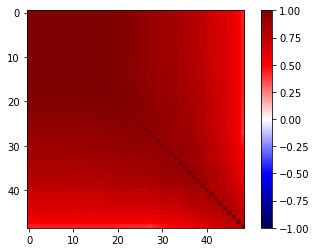

alpha = 1278.6779881462778 +/- 46.963461167314804
Yinf = 338.59245686197073 +/- 24.38329485943425
c = 67.68660059876682 +/- 257.0530303236615
alpha = [1187.2611151209092 - 1369.8683685890464]


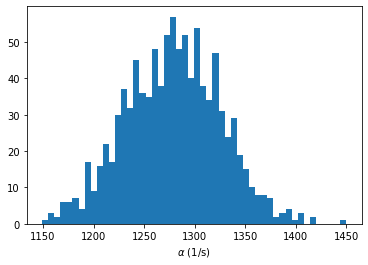

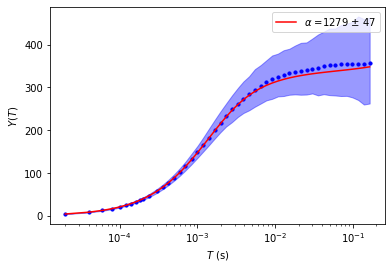

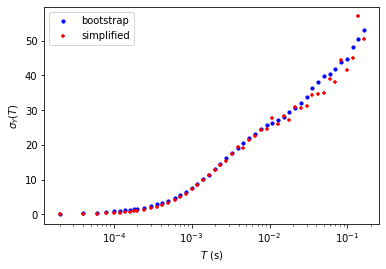

In [6]:
# Numerical experiment of zero power reactor noize
NSource = 100000
T0 = 2e-5
NT = 1000000
SigS = 1.0
SigF = 0.04
SigC = 0.062
count = simulateReactorNoise(NSource, T0, NT, SigS, SigF, SigC)


# Feynman-alpha method
klist = np.append( np.arange(1,11,1, dtype=np.int32), np.logspace(1, 13, 50, base=2, dtype= np.int32) ) 
klist = np.unique(klist)
T, Y, Yerr = calcY(count, T0, klist)
popt, pcov = curve_fit(Yfunc, T, Y, sigma=Yerr, absolute_sigma=True)


# Moving block bootstrap method
NB = 1000 # sample size of bootstrap replicates, NB>=1000 is recommended
NB =  np.max( [len(Y)+len(popt), NB] )
print("Bootstrap resample size = {}".format(NB))
Ybs = np.zeros( (NB, len(Y)) )
for b in range(NB):
    cbs = movingBlockBootstrap(count, klist)
    T, Ybs[b,:], tmp = calcY(cbs, T0, klist)

Ycov = np.cov(Ybs.T, ddof=1)
Ycor = np.corrcoef(Ybs.T)
plt.imshow(Ycor, cmap="seismic")
plt.clim([-1.0, 1.0])
plt.colorbar()
plt.show()

p0 = popt.copy()
poptbs = np.zeros((NB,len(p0)))
for b in range(NB):
    poptbs[b,:], pcovbs = curve_fit(Yfunc, T, Ybs[b,:], p0=p0, sigma=Ycov, absolute_sigma=True)

poptave = np.mean(poptbs, axis=0)
poptstd = np.std(poptbs, ddof=1, axis=0)
label = ["alpha", "Yinf", "c"]
for i in range(len(poptave)):
    print("{0} = {1} +/- {2}".format(label[i], poptave[i], poptstd[i]))

alpha_ave = np.mean(poptbs[:,0])
alpha_err = np.std(poptbs[:,0], ddof=1)
print("alpha = [{0} - {1}]".format(np.quantile(poptbs[:,0], 0.025), np.quantile(poptbs[:,0], 0.975)))
plt.hist(poptbs[:,0], bins=50)
plt.xlabel("$\\alpha$ (1/s)")
plt.plot()
plt.show()

plt.scatter(T, Ybs.mean(axis=0), marker="o", s=10, color="blue")
plt.fill_between(T, np.quantile(Ybs, 0.025, axis=0), np.quantile(Ybs, 0.975, axis=0), color="blue", alpha=0.4)
plt.plot(T, Yfunc(T, *poptave), "r-", label="$\\alpha$ ={0:.0f} $\pm$ {1:.0f}".format(alpha_ave, alpha_err))
plt.xscale("log")
plt.xlabel("$T$ (s)")
plt.ylabel("$Y(T)$")
plt.legend()
plt.show()

plt.scatter(T, Ybs.std(axis=0, ddof=1), marker="o", s=10, color="blue", label="bootstrap")
plt.scatter(T, Yerr, marker="+", s=10, color="red", label="simplified")
plt.xscale("log")
plt.xlabel("$T$ (s)")
plt.ylabel("$\sigma_{Y}(T)$")
plt.legend()
plt.show()